## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

In [73]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

In [119]:
from skimage import io
import cv2
import matplotlib.pyplot as plt
import numpy as np

print(cv2.__version__)

4.12.0


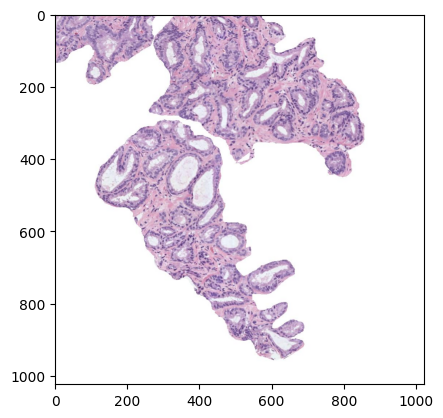

In [162]:
img = io.imread('./histo_2.jpg')
# normalización de pixels a [0,1]
img_norm = img / 255
plt.imshow(img_norm)
plt.show()



#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [76]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

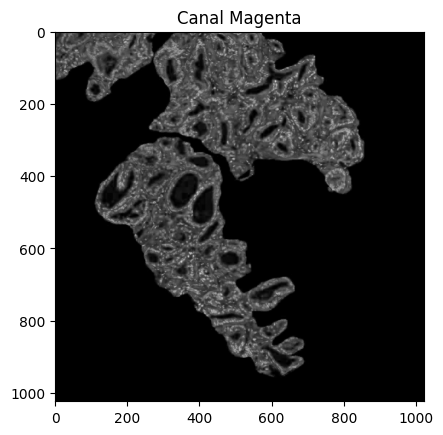

In [163]:
with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(img_norm, axis=2)
    # Extrae los canales de acuerdo con la ecuación del power point
    C = (1-img_norm[:,:,0]-K)/(1-K)
    M = (1-img_norm[:,:,1]-K)/(1-K)
    Y = (1-img_norm[:,:,2]-K)/(1-K)

CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
C,M,Y,K = cv2.split(CMYK)
plt.imshow(M.astype('uint8'), cmap='gray')
plt.title('Canal Magenta')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [78]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

In [164]:
# convertimos el formato a float32 para que sea compatible con cv2
img_norm_float32 = np.float32(img_norm)

# Convertimos la imagen RGB leida con skimage a formato BGR para poder utilizar la librería cv2
img_norm_bgr = cv2.cvtColor(img_norm_float32, cv2.COLOR_RGB2BGR)

# convertimos la imagen a escala de grises
img_gray = cv2.cvtColor(img_norm_bgr, cv2.COLOR_BGR2GRAY)

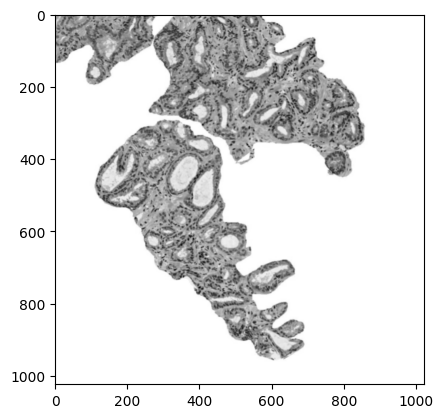

In [165]:
# Filtro Gaussiano de 5x5
img_gray_gaus = cv2.GaussianBlur(img_gray, (5,5), 0)
plt.imshow(img_gray_gaus, cmap='gray')
plt.show()


Umbral calculado por Otsu: 210.0


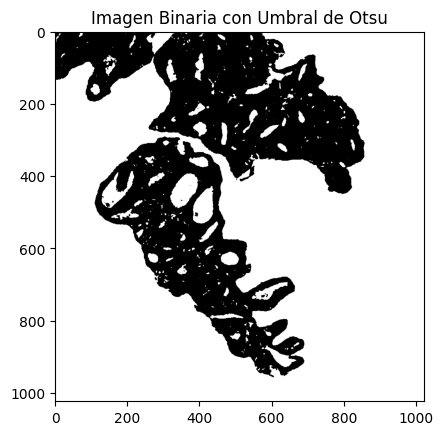

In [166]:
# Fijamos el umbral con el método de OTSU de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.

img_gray_gaus_uint8 = (img_gray_gaus * 255).astype(np.uint8)

ret, img_thresh = cv2.threshold(img_gray_gaus_uint8, 0, 255, cv2.THRESH_OTSU)

# normalizamos de nuevo a [0,1]
img_thresh_norm = (img_thresh / 255).astype(np.uint8)

print('Umbral calculado por Otsu:', ret)

# Visualizar la imagen binaria resultante
plt.imshow(img_thresh_norm, cmap='gray')
plt.title('Imagen Binaria con Umbral de Otsu')
plt.show()



#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [82]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

In [167]:
from skimage.measure import label, regionprops

label_image, num = label(img_thresh_norm, return_num=True)
print('número de objetos: ', num)
regions = regionprops(label_image)

# Inicializar contadores de regiones
small_regions = 0
large_regions = 0

# Iterate through each detected region and count based on area
for region in regions:
    if region.area < 300:
        small_regions += 1
    else:
        large_regions += 1

# Print the final counts
print(f"Objetos con menos de 300 pixels: {small_regions}")
print(f"Objetos con almenos 300 pixels : {large_regions}")



número de objetos:  329
Objetos con menos de 300 pixels: 300
Objetos con almenos 300 pixels : 29


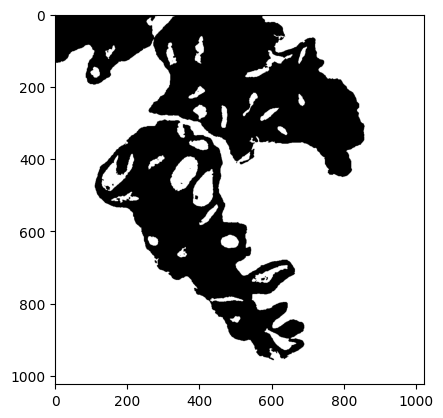

In [168]:
from skimage import morphology

img_thresh_bool = img_thresh_norm.astype(bool)

img_thresh_norm_clean = morphology.remove_small_objects(img_thresh_bool, min_size = 300)

plt.imshow(img_thresh_norm_clean, cmap='gray')

#pixel_comparison = (img_thresh_norm == img_thresh_norm_clean)
#are_equal = np.all(pixel_comparison)
#print('Las imágenes son iguales:', are_equal)

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [143]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.

In [169]:
def find_two_seeds(img):
  label_image, num = label(img, return_num=True)
  regions = regionprops(label_image)
  # Sort the regions by area in descending order
  regions.sort(key=lambda r: r.area, reverse=True)

  # Get the centroid (y, x) of the two largest regions
  y1, x1 = regions[0].centroid
  y2, x2 = regions[1].centroid

  # Convert to integer and swap to (x, y) for cv2 compatibility
  seed1 = (int(x1), int(y1))
  seed2 = (int(x2), int(y2))

  return seed1, seed2

 seed 1: (549, 590), pixel value: 1
 seed 2: (357, 440), pixel value: 1


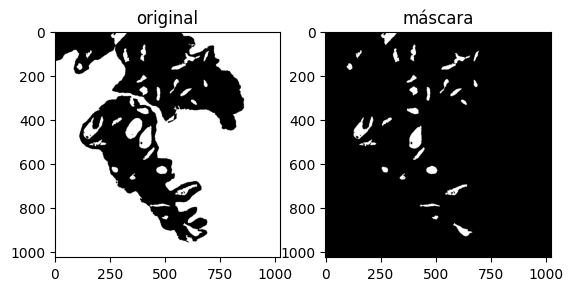

In [170]:
# Crear una copia de la imagen
mask = img_thresh_norm_clean.copy().astype(np.uint8)

# Definir una imagen negra de referencia
h, w = img_thresh_norm_clean.shape
ref = np.zeros((h+2, w+2), np.uint8)

seed1, seed2 = find_two_seeds(mask)
#seed_1 = (0,0)
#seed_2 = (h-1, w-1)

print(f" seed 1: {seed1}, pixel value: {mask[seed1[0],seed1[1]]}")
print(f" seed 2: {seed2}, pixel value: {mask[seed2[0],seed2[1]]}")

cv2.floodFill(mask, ref, seed1, 0)  # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición
cv2.floodFill(mask, ref, seed2, 0)  # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_thresh_norm_clean, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(mask, cmap='gray'), ax[1].set_title('máscara')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

In [88]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

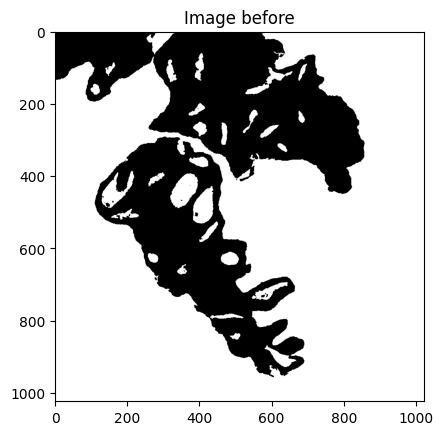

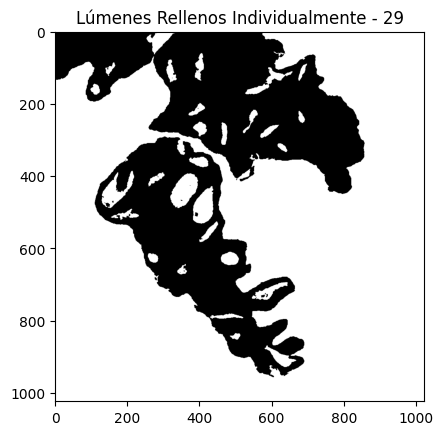

In [176]:
import numpy as np
from skimage import measure
from scipy.ndimage import binary_fill_holes as bfh

# Assume 'img_thresh_norm_clean' is your binary image with the 29 objects
# (and tissue=0, lumens=1, background=1)

# 1. Label all objects in the image
labeled_image = measure.label(img_thresh_norm_clean)

# 2. Get the properties for each region
regions = measure.regionprops(labeled_image)

# 3. Create a blank image to build the filled result
filled_lumens_image = np.zeros_like(img_thresh_norm_clean, dtype=np.uint8)

lumen_counter = 0

# 4. Loop through each detected region
for region in regions:
    # 5. Filter for objects larger than 300 pixels
    if region.area > 300:
        lumen_counter += 1
        # 6. Get a local mask of the object
        # The 'image' property gives a small binary mask of just this object
        object_mask = region.image

        # 7. Invert the local mask to prepare it for filling
        inverted_mask = np.logical_not(object_mask)

        # 8. Fill the holes within this single inverted mask
        filled_mask = bfh(inverted_mask)

        # 9. Invert the filled mask back to its original orientation
        # This gives a filled white object
        filled_object = np.logical_not(filled_mask)

        # 10. Place the filled object back into the final image at its original location
        minr, minc, maxr, maxc = region.bbox
        filled_lumens_image[minr:maxr, minc:maxc] = np.logical_or(
            filled_lumens_image[minr:maxr, minc:maxc], filled_object
        )

# The 'filled_lumens_image' now contains the original objects with their holes filled individually
plt.imshow(img_thresh_norm_clean, cmap='gray')
plt.title('Image before')
plt.show()
print()
plt.imshow(filled_lumens_image, cmap='gray')
plt.title(f"Lúmenes Rellenos Individualmente - {lumen_counter}")
plt.show()

In [172]:
#from scipy.ndimage import binary_fill_holes as bfh

#img_borders = img_thresh_norm_clean.copy()
#img_filled_borders = bfh(img_borders).astype(np.uint8)

#plt.imshow(img_filled_borders, cmap='gray')
#plt.title('Máscara Lumen Rellena')
#plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [90]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
import cv2

# Assuming these variables exist from previous steps:
# - original_color_image: Your original image in color
# - filled_lumens_image: Your filled binary image with 29 objects

# 1. Label all the filled objects
labeled_filled_lumens = measure.label(filled_lumens_image)

# 2. Get the properties for each region
regions = measure.regionprops(labeled_filled_lumens)

# 3. Create a copy of the original image to draw the boundaries on
image_with_boundaries = np.copy(img)

# 4. Loop through each detected region and find its boundary
for region in regions:
    # Filter for objects larger than 300 pixels
    if region.area > 300:
        # Create a full-size mask for the single object
        single_object_mask = (labeled_filled_lumens == region.label)

        # *** NEW: Clean up the mask with a morphological closing operation ***
        # This will fill small holes and smooth the boundary
        # The 'square' footprint with size 3 is a good starting point
        cleaned_mask = morphology.binary_closing(single_object_mask, morphology.square(3))

        # Erode the cleaned mask by 1 pixel
        eroded_mask = morphology.binary_erosion(cleaned_mask)

        # Subtract the eroded mask from the cleaned mask to get the boundary pixels
        boundary_mask = np.logical_xor(cleaned_mask, eroded_mask)

        # Get the coordinates of the boundary pixels
        rows, cols = np.where(boundary_mask)

        # Set the pixels at these coordinates to green
        # Assuming your image is in BGR format
        image_with_boundaries[rows, cols, 0] = 0   # Blue channel
        image_with_boundaries[rows, cols, 1] = 255 # Green channel
        image_with_boundaries[rows, cols, 2] = 0   # Red channel

# Display the final image
plt.imshow(image_with_boundaries)
plt.title('29 Objetos con Líneas Verdes (Método Morfológico Mejorado)')
plt.show()

NameError: name 'filled_lumens_image' is not defined

Number of contours non on border, 13


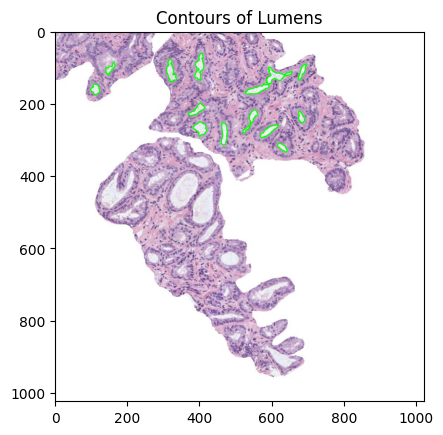

In [191]:
#plt.imshow(img_norm)

# find contours

img_contour = img.copy()

contours, _ = cv2.findContours(filled_lumens_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered_lumens_contours = []

for contour in contours:
    x, y, width, height = cv2.boundingRect(contour)
    if ( x == 0 or y == 0 or (x + width) == w or (y + height) == h):
        pass
    else:
        filtered_lumens_contours.append(contour)

print(f"Number of contours non on border, {len(filtered_lumens_contours)}")

cv2.drawContours(img_contour, filtered_lumens_contours, -1, (0, 255, 0), 2)

plt.imshow(img_contour)
plt.title('Contours of Lumens')
plt.show()

#### 7) Identificar y cropear el lumen más grande

In [92]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

In [1]:
# Assuming 'filtered_lumens_contours' is your list of 11 contours


# Find the largest contour
largest_lumen_contour = max(filtered_lumens_contours, key=cv2.contourArea)

# Obtener el cuadro delimitador (bounding box) de ese contorno
x, y, w, h = cv2.boundingRect(largest_lumen_contour)

# Crop
cropped_lumen = img[y:y+h, x:x+w]

plt.imshow(cv2.cvtColor(cropped_lumen, cv2.COLOR_BGR2RGB))
plt.title(f'Lumen de Mayor Área')
plt.axis('off')  # Ocultar los ejes para una mejor visualización
plt.show()

NameError: name 'image_with_boundaries' is not defined

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [133]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

In [193]:
import numpy as np
from skimage import measure
from scipy.spatial import distance

def max_feret_diameter(binary_image):
    """
    Calculates the maximum Feret's diameter (maximum caliper) of a single object.

    Parameters:
    binary_image (np.ndarray): A binary image (0s and 1s) containing a single object.

    Returns:
    float: The maximum Feret's diameter in pixels. Returns 0 if no object is found.
    """
    # Use regionprops to get the coordinates of the object
    regions = measure.regionprops(binary_image.astype(np.uint8))

    # Check if an object was found
    if not regions:
        return 0

    # Get the coordinates of the pixels in the object's convex hull
    # The 'convex_image' property gives a mask of the convex hull
    convex_coords = np.argwhere(regions[0].convex_image)

    # Check if the convex hull has enough points
    if len(convex_coords) < 2:
        return 0

    # Use scipy's optimized pdist to calculate all pairwise distances on the convex hull
    # This is much faster than a brute-force nested Python loop
    all_distances = distance.pdist(convex_coords, 'euclidean')

    # Return the maximum distance found
    return np.max(all_distances)

In [ ]:
# Vamos a extraer diferentes descriptores geométricos que nos ayudarán a caracterizar los objetos.
from tabulate import tabulate
import math

# 1. Get the object number of the largest lumen
x, y = largest_lumen_contour[0][0]
object_number = new_lab[y, x]

# 2. Extract metrics for only that specific object
# Create a mask for the single object
objeto = new_lab == object_number

# Run regionprops on the single object's mask
prop = regionprops(objeto.astype(np.uint8))

headers = ['Métrica','Valor']
# Initialize the lists to store the metrics
#A, BB, CA, E, ED, EX, MA, MiA, OR, P, S, CO, R = [], [], [], [], [], [], [], [], [], [], [], [], []
#A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO,R = ['Área'], ['Área de la bounding box'], ['Área convexa'], ['Exentricidad'], ['Diámetro equivalente'], \
#['Extensión'], ['Longitud del eje mayor'], ['Longitud del eje menor'], ['Orientación'], ['Perímetro'], ['Solidez'], ['Compacidad'], ['Rectangularity']

A, BB, CA, E, ED, EX, MA, MiA, OR, P, S, CO = [], [], [], [], [], [], [], [], [], [], [], []
A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO = ['Área'], ['Área de la bounding box'], ['Área convexa'], ['Exentricidad'], ['Diámetro equivalente'], \
['Extensión'], ['Longitud del eje mayor'], ['Longitud del eje menor'], ['Orientación'], ['Perímetro'], ['Solidez'], ['Compacidad']   #, ['Rectangularity']

# Append the metrics for the single object
# You access the properties from prop[0] since there is only one object
A.append(np.round(prop[0].area, 4))
BB.append(np.round(prop[0].bbox_area, 4))
CA.append(np.round(prop[0].convex_area, 4))
E.append(np.round(prop[0].eccentricity, 4))
ED.append(np.round(prop[0].equivalent_diameter, 4))
EX.append(np.round(prop[0].extent, 4))
MA.append(np.round(prop[0].major_axis_length, 4))
MiA.append(np.round(prop[0].minor_axis_length, 4))
OR.append(np.round(prop[0].orientation, 4))
P.append(np.round(prop[0].perimeter, 4))
S.append(np.round(prop[0].solidity, 4))
CO.append(np.round(4 * math.pi * prop[0].area / prop[0].perimeter**2, 4))
#R.append(np.round(prop[0].area / prop[0].bbox_area, 4))

#my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
#          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO), tuple(R)]

my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO)]

print(tabulate(my_data, headers=headers))

max_feret = max_feret_diameter(objeto)
print(f"Maximum Feret's Diameter: {max_feret:.2f} pixels")


Métrica                        Valor
-----------------------  -----------
Área                     316611
Área de la bounding box  842752
Área convexa             456001
Exentricidad                  0.8566
Diámetro equivalente        634.919
Extensión                     0.3757
Longitud del eje mayor     1084.5
Longitud del eje menor      559.612
Orientación                  -0.5833
Perímetro                  6411.88
Solidez                       0.6943
Compacidad                    0.0968


In [ ]:
# Vamos a extraer diferentes descriptores geométricos que nos ayudarán a caracterizar los objetos.
# pip install tabulate
from tabulate import tabulate
import math

new_lab, new_num = label(mask, return_num=True)

# Extraemos las característicias geométricas
headers = ['','Raro', 'Rayo', 'Círculo', 'Cuadrado', 'Triángulo', 'Rombo']
A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO,R = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness'], ['rectangularity']

for i in range(1,new_num+1):
    objeto = new_lab == i
    prop = regionprops(objeto.astype(np.uint8))

    A.append(np.round(prop[0].area, 4))
    BB.append(np.round(prop[0].bbox_area, 4))
    CA.append(np.round(prop[0].convex_area, 4))
    E.append(np.round(prop[0].eccentricity, 4))
    ED.append(np.round(prop[0].equivalent_diameter, 4))
    EX.append(np.round(prop[0].extent, 4))
    MA.append(np.round(prop[0].major_axis_length, 4))
    MiA.append(np.round(prop[0].minor_axis_length, 4))
    OR.append(np.round(prop[0].orientation, 4))
    P.append(np.round(prop[0].perimeter, 4))
    S.append(np.round(prop[0].solidity, 4))
    CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
    R.append(np.round(prop[0].area/prop[0].bbox_area, 4))


my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO), tuple(R)]

print(tabulate(my_data, headers=headers))